In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statistics as stats
import random as rn
import os
import tensorflow.compat.v1 as tf
import keras
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, GaussianNoise, GaussianDropout
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.activations import relu
from keras import initializers as init
from keras.constraints import max_norm
from keras.utils.vis_utils import plot_model
from tensorflow.compat.v1.keras import backend as K
from math import sqrt
from IPython.display import display
from matplotlib.lines import Line2D
from collections import defaultdict
from IPython.display import Image
from google.colab import files, drive
#drive.mount("drive")

# ensure repeatability
K.clear_session()
tf.reset_default_graph()
warnings.filterwarnings("ignore")

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(23)
rn.seed(23)
tf.random.set_random_seed(23)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

pd.set_option("display.max_columns", None)

In [2]:
# load df
df = pd.read_csv("FE_trainset.csv", index_col=0)
df_full = pd.read_csv("fullchem.csv", index_col=0)
labels = pd.read_csv("FE_labels.csv", sep="|")
labels.head()

,Type,AB,Site,Impurity
0,IV-IV,GeC,M_i_neut,Cl
1,IV-IV,C,M_A,Mo
2,II-VI,ZnS,M_i_B,Cs
3,IV-IV,SnC,M_i_neut,Br
4,II-VI,ZnS,M_i_A,Ta


In [3]:
# code to test for inf or na in pandas df
a = df.isna().any()
j = 0
k = 0
z = 0
for i in range(df.shape[1]):
    b = str(a[i])
    if b is "True":
        k+=1
    elif b is "False":
        j+=1
    else:
        z+=1

print(k)
print(j)
print(z)

# code to test for inf or na in pandas df
a = df_full.isna().any()
j = 0
k = 0
z = 0
for i in range(df_full.shape[1]):
    b = str(a[i])
    if b is "True":
        k+=1
    elif b is "False":
        j+=1
    else:
        z+=1

print(k)
print(j)
print(z)

0
229
0
0
736
0


In [4]:
class NeuralNetwork:
    def data_prep(df):
        """
        Function adds two additional descriptor columns for sc type and defect
        site, then standardized and one-hot encodes input and output
        """
        # load labels df - sc type, defect site, compound
        labels = pd.read_csv("FE_labels.csv", sep="|")
        labels.drop(columns=labels.iloc[:, 1:2], inplace=True)
        labels.drop(columns=labels.iloc[:, 2:3], inplace=True)
        
        # encode sc type and defect site and add to df
        enc = OrdinalEncoder(dtype=np.int)        
        enc_labels = enc.fit_transform(labels)
        labels = pd.DataFrame(enc_labels, columns=["Type", "Site"])
        df = pd.concat([df, labels], axis=1)

        # separate categorical and continuous data 
        categorical=pd.DataFrame()
        continuous=pd.DataFrame()

        # seperate x and y values
        y = df.iloc[:, 0:2]
        x = df.iloc[:, 2:1000000]

        for column in x.columns:
            if(x[column].dtypes == "int"):
                categorical[column]=x[column]
            elif(x[column].dtypes == "float"):
                continuous[column]=x[column]
            else:
                pass
                
        # one hot encode categorical data
        onehotencoder = OneHotEncoder()
        categorical = onehotencoder.fit_transform(categorical).toarray()
   
        # standardize continuous data
        input_scaler = StandardScaler()
        continuous = input_scaler.fit_transform(continuous)

        # re-combine categorical and continuous x values
        x = np.concatenate((continuous, categorical), axis=1)

        # standardize outputs (DFT predicted / output)
        output_scaler = StandardScaler()
        y = output_scaler.fit_transform(y)

        # concatenate x and y back to df
        df = pd.DataFrame(np.concatenate((y, x), axis=1))

        return (df, output_scaler, input_scaler)

    def graph_results(epochs, loss, val_loss, training_results,
                      testing_results):
    
        test_color = "#ff5042"  #red 
        train_color = "#080bb6"  #blue
        error_color = "#bababa"  #grey
        fig, ax = plt.subplots(figsize=(12, 7))
        x_plot = np.arange(0, epochs)
        for index in range(loss.shape[0]):
            ax.plot(x_plot, loss[index], label="Training Loss", color=train_color, 
                    lw=2)
            ax.plot(x_plot, val_loss[index], label="Validation Loss",
                    color=test_color, lw=2)
        ax.set_xlabel("Epoch Number", fontsize=15)
        ax.set_ylabel("Loss", fontsize=15)
        ax.set_ylim(0, 3)
        ax.set_title('Training/Validation Loss Functions', fontsize=20)
        legend_lines = [Line2D([0], [0], color=train_color, lw=4),
                        Line2D([0], [0], color=test_color, lw=4)]                                
        ax.legend(legend_lines, ["Loss", "Val. Loss"], fontsize=20)
        plt.show()

        #############################################################
        # plot results
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.subplots_adjust(hspace=.25, wspace = 0.175, top=.86)
        fig.suptitle("Formation Energies: NN Predictions VS. DFT Calc.", fontsize=20, va='top')
        fig.text(0.5, 0.02, 'DFT Calculations (eV)', ha='center', fontsize=17)
        fig.text(0.05, 0.5, 'Neural Network Prediction (eV)', va='center', rotation='vertical',
                fontsize=17)
        
        subtitle_size = 17
        test_alpha = 0.5
        train_alpha = 0.85
        scatter_size = 6.5

        # HA
        ax[0].set_title("dH (A-rich)", fontsize=subtitle_size)
        ax[0].errorbar(training_results["dH-A DFT"],
                       training_results["dH-A NN"],
                       yerr=training_results["dH-A Error"], fmt='o',
                       label="Train", ecolor=error_color, elinewidth=2.5,
                       alpha=train_alpha, color=train_color,
                       markersize=scatter_size, zorder=3)        
        ax[0].errorbar(testing_results["dH-A DFT"],
                       testing_results["dH-A NN"],
                       yerr=testing_results["dH-A Error"], fmt='o',
                       label="Test", ecolor=error_color, elinewidth=2.5,
                       alpha=test_alpha, color=test_color,
                       markersize=scatter_size, zorder=3)        
        lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
                np.max([ax[0].get_xlim(), ax[0].get_ylim()])]
        ax[0].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[0].set_xlim(lims)
        ax[0].set_ylim(lims)
        ax[0].legend(fontsize=subtitle_size)

        # HB
        ax[1].set_title("dH (B-rich)", fontsize=subtitle_size)
        ax[1].errorbar(training_results["dH-B DFT"],
                       training_results["dH-B NN"],
                       yerr=training_results["dH-B Error"], fmt='o',
                       label="Train", ecolor=error_color, elinewidth=2.5,
                       alpha=train_alpha, color=train_color,
                       markersize=scatter_size, zorder=3)        
        ax[1].errorbar(testing_results["dH-B DFT"],
                       testing_results["dH-B NN"],
                       yerr=testing_results["dH-B Error"], fmt='o',
                       label="Test", ecolor=error_color, elinewidth=2.5,
                       alpha=test_alpha, color=test_color,
                       markersize=scatter_size, zorder=3)        
        lims = [np.min([ax[1].get_xlim(), ax[1].get_ylim()]),
                np.max([ax[1].get_xlim(), ax[1].get_ylim()])]
        ax[1].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[1].set_xlim(lims)
        ax[1].set_ylim(lims)
        
        plt.show()

    def eval_catgr(x_test_HA, x_test_HB, y_test, output_scaler, model):
        y_test = output_scaler.inverse_transform(y_test)
        pred_test = model.predict([x_test_HA, x_test_HB])
        pred_test = output_scaler.inverse_transform(pred_test)

        test_RMSE_HA = sqrt(mean_squared_error(y_test[:,0], pred_test[:,0]))
        test_RMSE_HB = sqrt(mean_squared_error(y_test[:,1], pred_test[:,1]))

        return (test_RMSE_HA, test_RMSE_HB)
        
    def model_eval(model, prediction, x_train_HA, x_train_HB, x_test_HA, 
                   x_test_HB, y_train, y_test, output_scaler):
        """
        Prints out the RMSE trian and test values
        """
        y_train = output_scaler.inverse_transform(y_train)
        y_test = output_scaler.inverse_transform(y_test)

        pred_train = model.predict([x_train_HA, x_train_HB])
        pred_test = model.predict([x_test_HA, x_test_HB])

        pred_train = output_scaler.inverse_transform(pred_train)
        pred_test = output_scaler.inverse_transform(pred_test)
        
        train_RMSE_HA = sqrt(mean_squared_error(y_train[:,0], pred_train[:,0]))
        train_RMSE_HB = sqrt(mean_squared_error(y_train[:,1], pred_train[:,1]))
        test_RMSE_HA = sqrt(mean_squared_error(y_test[:,0], pred_test[:,0]))
        test_RMSE_HB = sqrt(mean_squared_error(y_test[:,1], pred_test[:,1]))

        print("- - - - - - - - - - - - - - - - - - - -")
        print("RMSE Training / Testing (eV):")
        print("dH (A-rich): %.4f / %.4f" % (train_RMSE_HA, test_RMSE_HA))
        print("dH (B-rich): %.4f / %.4f" % (train_RMSE_HB, test_RMSE_HB))
        print("- - - - - - - - - - - - - - - - - - - -")
        low_epoch = (np.argmin(prediction.history["val_loss"]) + 1)
        low_val_loss = np.amin(prediction.history["val_loss"])
        low_epoch_train = (np.argmin(prediction.history["loss"]) + 1)
        low_val_loss_train = np.amin(prediction.history["loss"])
        print("Lowest Val. loss: %.4f at %s epochs" % (low_val_loss, low_epoch))
        print("Lowest train loss: %.4f at %s epochs" % (low_val_loss_train, low_epoch_train))
        print("- - - - - - - - - - - - - - - - - - - -")        
        print("")

        return (train_RMSE_HA, train_RMSE_HB, test_RMSE_HA, test_RMSE_HB,
                pred_train, pred_test, y_train, y_test)

    def pred_fullchem(df_full, model, input_scaler):
        # load full chem labels df - sc type, defect site, compound
        labels = pd.read_csv("fullchem_labels.csv", sep="|")
        labels.drop(columns=labels.iloc[:, 1:2], inplace=True)
        labels.drop(columns=labels.iloc[:, 2:3], inplace=True)

        # encode sc type and defect site and add to df
        enc = OrdinalEncoder(dtype=np.int)        
        enc_labels = enc.fit_transform(labels)
        labels = pd.DataFrame(enc_labels, columns=["Type", "Site"])
        x = pd.concat([df_full, labels], axis=1)

        # separate categorical and continuous data 
        categorical=pd.DataFrame()
        continuous=pd.DataFrame()

        for column in x.columns:
            if(x[column].dtypes == "int"):
                categorical[column]=x[column]
            elif(x[column].dtypes == "float"):
                continuous[column]=x[column]
            else:
                pass

        # one hot encode categorical data
        onehotencoder = OneHotEncoder()
        categorical = onehotencoder.fit_transform(categorical).toarray()
   
        # standardize continuous data
        continuous = input_scaler.fit_transform(continuous)

        # re-combine categorical and continuous x values
        x = np.concatenate((continuous, categorical), axis=1)
        x = pd.DataFrame(x)

        x_HA = x.iloc[:, 0:108]
        x_HB = x.iloc[:, 108:227]
        onehot_label = x.iloc[:, 736:744]

        for dff in ([x_HA, x_HB]):
            dff = pd.concat([dff, onehot_label], axis=1)

        full_predict = model.predict([x_HA, x_HB])

        return (full_predict)

    def run_k_fold(df, epochs, bs, lr, decay, dropout, noise, k_reg, 
                   hid_layer_neurons, verbose, folds, repeats, rs, graph, 
                   output_scaler, input_scaler, df_full, beta1, beta2, amsgrad):   
        """
        This functions performs the k_fold stratify split and runs the neural 
        network model for predictions.
        """
        des_labels = pd.read_csv("FE_labels.csv", sep="|")
        dict_labels = pd.read_csv("FE_labels.csv", sep="|")
        dict_labels.columns = ["SC_type", "AB_compound", "Def_site", "Impuirty_atom"]
        des_labels.drop(columns=des_labels.iloc[:, 1:2], inplace=True)
        des_labels.drop(columns=des_labels.iloc[:, 2:3], inplace=True)
        df = pd.concat([des_labels, df, dict_labels], axis=1)

        enc = OrdinalEncoder(dtype=np.int)
        encode_labels = enc.fit_transform(des_labels)
        labels = pd.DataFrame(encode_labels, columns=["Type", "Site"])
        labels = labels.applymap(str)
        labels = labels[["Type", "Site"]].apply(lambda x: ''.join(x), axis=1)

        # encode the new string col to 0-14 (15 total classes - 3 sctypes x 5 defsites)
        combined_labels = np.array(labels).reshape(-1, 1)
        combined_lables = enc.fit_transform(combined_labels)

        total_folds = 0
        fold_num = 0
        train_rmse_HA = []
        train_rmse_HB = []
        test_rmse_HA = []
        test_rmse_HB = []

        sub_test_rmse_HA = []
        sub_test_rmse_HB = []

        int_test_rmse_HA = []
        int_test_rmse_HB = []

        IIVI_test_rmse_HA = []
        IIVI_test_rmse_HB = []

        IIIV_test_rmse_HA = []
        IIIV_test_rmse_HB = []

        IVIV_test_rmse_HA = []
        IVIV_test_rmse_HB = []

        loss = []
        val_loss = []

        Y_train = np.empty(0)     
        Y_test = np.empty(0)     
        PRED_train = np.empty(0)   
        PRED_test = np.empty(0)
        TRAIN_label = np.empty(0)
        TEST_label = np.empty(0)

        full_pred_HA = np.empty(0)
        full_pred_HB = np.empty(0)
        
        for random in range(1, repeats+1):
            fold_num+=1
            stratified = StratifiedKFold(n_splits=folds, shuffle=True,
                                         random_state=(random*10))
            for train_index, test_index in stratified.split(df, combined_labels):
                total_folds+=1

                train = df.loc[train_index]
                test = df.loc[test_index]
                
                # train split
                y_train = train.iloc[:, 2:4]
                x_train_HA = train.iloc[:, 4:112]
                x_train_HB = train.iloc[:, 112:231]

                # test split
                y_test = test.iloc[:, 2:4]
                x_test_HA = test.iloc[:, 4:112]
                x_test_HB = test.iloc[:, 112:231]

                # sc type and defect site one-hot labels
                onehot_label_train = train.iloc[:, 231:239]
                onehot_label_test = test.iloc[:, 231:239]

                # labels for results dictionary
                train_label = train.iloc[:, 239:243]
                test_label = test.iloc[:, 239:243]

                # concat one hot labels with each respective df
                for dff in ([x_train_HA, x_train_HB]):
                    dff = pd.concat([dff, onehot_label_train], axis=1)

                for dff in ([x_test_HA, x_test_HB]):
                    dff = pd.concat([dff, onehot_label_test], axis=1)

                # sc type and defect site split
                sub_test_index = ((test.Site=="M_A") +
                                  (test.Site=="M_B"))
                int_test_index = ((test.Site=="M_i_A") +
                                  (test.Site=="M_i_B") + 
                                  (test.Site=="M_i_neut"))

                sub_test = test.loc[sub_test_index]
                int_test = test.loc[int_test_index]         
                IIVI_test = test.loc[test.Type=="II-VI"]
                IIIV_test = test.loc[test.Type=="III-V"]
                IVIV_test = test.loc[test.Type=="IV-IV"]

                y_sub_test = sub_test.iloc[:, 2:4]
                x_sub_test_HA = sub_test.iloc[:, 4:112]
                x_sub_test_HB = sub_test.iloc[:, 112:231]
                one_hot_label = sub_test.iloc[:, 231:239]
                for dff in ([x_sub_test_HA, x_sub_test_HB]):
                    dff = pd.concat([dff, one_hot_label], axis=1)

                y_int_test = int_test.iloc[:, 2:4]
                x_int_test_HA = int_test.iloc[:, 4:112]
                x_int_test_HB = int_test.iloc[:, 112:231]
                one_hot_label = int_test.iloc[:, 231:239]
                for dff in ([x_int_test_HA, x_int_test_HB]):
                    dff = pd.concat([dff, one_hot_label], axis=1)

                y_IIVI_test = IIVI_test.iloc[:, 2:4]
                x_IIVI_test_HA = IIVI_test.iloc[:, 4:112]
                x_IIVI_test_HB = IIVI_test.iloc[:, 112:231]
                one_hot_label = IIVI_test.iloc[:, 231:239]
                for dff in ([x_IIVI_test_HA, x_IIVI_test_HB]):
                    dff = pd.concat([dff, one_hot_label], axis=1)

                y_IIIV_test = IIIV_test.iloc[:, 2:4]
                x_IIIV_test_HA = IIIV_test.iloc[:, 4:112]
                x_IIIV_test_HB = IIIV_test.iloc[:, 112:231]
                one_hot_label = IIIV_test.iloc[:, 231:239]
                for dff in ([x_IIIV_test_HA, x_IIIV_test_HB]):
                    dff = pd.concat([dff, one_hot_label], axis=1)

                y_IVIV_test = IVIV_test.iloc[:, 2:4]
                x_IVIV_test_HA = IVIV_test.iloc[:, 4:112]
                x_IVIV_test_HB = IVIV_test.iloc[:, 112:231]
                one_hot_label = IVIV_test.iloc[:, 239:239]
                for dff in ([x_IVIV_test_HA, x_IVIV_test_HB]):
                    dff = pd.concat([dff, one_hot_label], axis=1)


                in_dim_HA = x_train_HA.shape[1]
                in_dim_HB = x_train_HB.shape[1]

                (model, prediction
                ) = NeuralNetwork.train_model(x_train_HA, x_train_HB, y_train, 
                                              x_test_HA, x_test_HB, y_test, 
                                              in_dim_HA, in_dim_HB, epochs, 
                                              bs, lr, decay, dropout, noise, 
                                              k_reg, hid_layer_neurons, verbose,
                                              beta1, beta2, amsgrad)
                
                # print RMSE values
                print("K-Fold repeat #: " + str(fold_num))
                print("K-Fold ovrall #: " + str(total_folds))
                (train_RMSE_HA, train_RMSE_HB, test_RMSE_HA, test_RMSE_HB,
                 pred_train, pred_test, y_train, 
                 y_test) = NeuralNetwork.model_eval(model, prediction,
                                                    x_train_HA, x_train_HB, 
                                                    x_test_HA, x_test_HB, 
                                                    y_train, y_test, 
                                                    output_scaler)
                
                #substitutional site evaluation
                (test_sub_RMSE_HA,
                 test_sub_RMSE_HB) = NeuralNetwork.eval_catgr(x_sub_test_HA,
                                                              x_sub_test_HB,
                                                              y_sub_test,
                                                              output_scaler,
                                                              model)
                 
                #interstitial site evaluation
                (test_int_RMSE_HA,
                 test_int_RMSE_HB) = NeuralNetwork.eval_catgr(x_int_test_HA,
                                                              x_int_test_HB,
                                                              y_int_test,
                                                              output_scaler,
                                                              model)
                 
                #IIVI site evaluation
                (test_IIVI_RMSE_HA,
                 test_IIVI_RMSE_HB) = NeuralNetwork.eval_catgr(x_IIVI_test_HA,
                                                              x_IIVI_test_HB,
                                                              y_IIVI_test,
                                                              output_scaler,
                                                              model)

                #IIIV site evaluation
                (test_IIIV_RMSE_HA,
                 test_IIIV_RMSE_HB) = NeuralNetwork.eval_catgr(x_IIIV_test_HA,
                                                              x_IIIV_test_HB,
                                                              y_IIIV_test,
                                                              output_scaler,
                                                              model)

                #IVIV site evaluation
                (test_IVIV_RMSE_HA,
                 test_IVIV_RMSE_HB) = NeuralNetwork.eval_catgr(x_IVIV_test_HA,
                                                              x_IVIV_test_HB,
                                                              y_IVIV_test,
                                                              output_scaler,
                                                              model)

                # Predict full 12k points
                full_predict = NeuralNetwork.pred_fullchem(df_full, model,
                                                           input_scaler)
                
                full_predict = output_scaler.inverse_transform(full_predict)
                full_predict = np.array(full_predict)
                full_predict_HA = full_predict[:,0]
                full_predict_HB = full_predict[:,1]
                full_pred_HA = np.append(full_pred_HA, full_predict_HA)
                full_pred_HB = np.append(full_pred_HB, full_predict_HB)

                # append each train and test RMSE
                train_rmse_HA.append(train_RMSE_HA)
                train_rmse_HB.append(train_RMSE_HB)
                test_rmse_HA.append(test_RMSE_HA)
                test_rmse_HB.append(test_RMSE_HB)

                sub_test_rmse_HA.append(test_sub_RMSE_HA)
                sub_test_rmse_HB.append(test_sub_RMSE_HB)

                int_test_rmse_HA.append(test_int_RMSE_HA)
                int_test_rmse_HB.append(test_int_RMSE_HB)
                
                IIVI_test_rmse_HA.append(test_IIVI_RMSE_HA)
                IIVI_test_rmse_HB.append(test_IIVI_RMSE_HB)

                IIIV_test_rmse_HA.append(test_IIIV_RMSE_HA)
                IIIV_test_rmse_HB.append(test_IIIV_RMSE_HB)

                IVIV_test_rmse_HA.append(test_IVIV_RMSE_HA)
                IVIV_test_rmse_HB.append(test_IVIV_RMSE_HB)

                # loss functions
                loss.append(prediction.history["loss"])
                val_loss.append(prediction.history["val_loss"])

                # appending train and test results and labels for y/DFT and pred/NN
                y_train = np.array(y_train)   #dft
                y_test = np.array(y_test)     #dft
                pred_train = np.array(pred_train)  #NN
                pred_test = np.array(pred_test)     #NN

                Y_train = np.append(Y_train, y_train)   #dft
                Y_test = np.append(Y_test, y_test)   #dft
                PRED_train = np.append(PRED_train, pred_train)  #NN
                PRED_test = np.append(PRED_test, pred_test) #NN

                train_label = np.asarray(train_label)
                test_label = np.asarray(test_label)
                TRAIN_label = np.append(TRAIN_label, train_label)
                TEST_label = np.append(TEST_label, test_label)

        # reshape loss functions to have length of # of epochs for plotting
        loss = np.array(loss).reshape(-1, epochs)
        val_loss = np.array(val_loss).reshape(-1, epochs)

        # reshape and calculate uncertainties for full 12k points
        full_pred_HA = full_pred_HA.reshape(-1, repeats*folds)
        full_pred_HB = full_pred_HB.reshape(-1, repeats*folds)

        stdev_HA = pd.DataFrame(full_pred_HA.std(axis=1), 
                             columns=["dH (A-rich) std"])
        stdev_HB = pd.DataFrame(full_pred_HB.std(axis=1), 
                             columns=["dH (B-rich) std"])
        
        mean_HA = pd.DataFrame(full_pred_HA.mean(axis=1), 
                             columns=["dH (A-rich) mean"])
        mean_HB = pd.DataFrame(full_pred_HB.mean(axis=1), 
                             columns=["dH (B-rich) mean"])
        
        labels = pd.read_csv("fullchem_labels.csv", sep="|")
        ovr_predictions = pd.concat([labels,
                                     mean_HA, stdev_HA,
                                     mean_HB, stdev_HB],
                                    axis=1)
        ovr_predictions.to_excel(r"FE_fullchem_predictions.xlsx", index=False)        ####################saves uncertainty data

        # zip dft and NN together
        train_values = np.hstack(zip(Y_train, PRED_train)).reshape(-1, 4)
        test_values = np.hstack(zip(Y_test, PRED_test)).reshape(-1, 4)

        #concat results with labels
        train_results = np.concatenate((TRAIN_label.reshape(-1,4), 
                                        train_values), axis=1)
        test_results = np.concatenate((TEST_label.reshape(-1,4),
                                       test_values), axis=1)
        train_results = pd.DataFrame(train_results)
        test_results = pd.DataFrame(test_results)
        train_results.columns = ["SC_type", "AB_compound", "Def_site",
                                 "Impuirty_atom", "dH-A DFT", "dH-A NN", 
                                 "dH-B DFT", "dH-B NN"]
        test_results.columns = train_results.columns

        # change results to numeric in pd.df
        train_results[["dH-A DFT", "dH-A NN", "dH-B DFT",
                       "dH-B NN"]] = train_results[["dH-A DFT", "dH-A NN",
                                                    "dH-B DFT",
                                                    "dH-B NN"]].apply(
                                                        pd.to_numeric)

        test_results[["dH-A DFT", "dH-A NN", "dH-B DFT",
                      "dH-B NN"]] = test_results[["dH-A DFT", "dH-A NN",
                                                  "dH-B DFT",
                                                  "dH-B NN"]].apply(
                                                      pd.to_numeric)

        # categorizes results by each system combination
        train_grouped = train_results.groupby(["SC_type", "AB_compound", 
                                              "Def_site", "Impuirty_atom"])
        test_grouped = test_results.groupby(["SC_type", "AB_compound", 
                                            "Def_site", "Impuirty_atom"])

        train_mean = train_grouped.mean()
        test_mean = test_grouped.mean()

        train_std = pd.DataFrame()
        test_std = pd.DataFrame()
        train_std[["dH-A Error",
                   "dH-B Error"]]  = train_grouped[["dH-A NN", "dH-B NN"]].std()
        test_std[["dH-A Error",
                   "dH-B Error"]]  = test_grouped[["dH-A NN", "dH-B NN"]].std()

        training_results = pd.concat([train_mean,
                                      train_std], axis=1).sort_index(axis=1,
                                                             ascending=False)
        testing_results = pd.concat([test_mean,
                                     test_std], axis=1).sort_index(axis=1,
                                                           ascending=False)

        training_results.to_csv("train_results.csv")
        testing_results.to_csv("test_results.csv")

        # graph loss functions
        if graph is True:
            NeuralNetwork.graph_results(epochs, loss, val_loss,
                                        training_results, testing_results)
        else:
            pass
        
        # calculate mean and stdev of train and test RMSE and display df
        # summary = pd.DataFrame([train_RMSE, test_RMSE]).T
        # summary.columns = ["Train RMSE", "Test RMSE"]
        # display(summary)
        print("Average Train / Test RMSE with Uncertainty:")
        print("dH (A-rich): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_HA), stats.stdev(train_rmse_HA),
                 stats.mean(test_rmse_HA), stats.stdev(test_rmse_HA)))
        print("dH (B-rich): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_HB), stats.stdev(train_rmse_HB),
                 stats.mean(test_rmse_HB), stats.stdev(test_rmse_HB)))
        print("")
        print("RMSE by defect site and SC type")
        print("---------------------------------------------------------")
        print("dH (A-rich)")
        print("Sub site: %.3f +/- %.3f"
              % (stats.mean(sub_test_rmse_HA), 
                 stats.stdev(sub_test_rmse_HA)))
        print("Int site: %.3f +/- %.3f"
              % (stats.mean(int_test_rmse_HA), 
                 stats.stdev(int_test_rmse_HA)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_HA), 
                 stats.stdev(IIVI_test_rmse_HA)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_HA), 
                 stats.stdev(IIIV_test_rmse_HA)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_HA), 
                 stats.stdev(IVIV_test_rmse_HA))) 
        print("dH (B-rich)")
        print("Sub site: %.3f +/- %.3f"
              % (stats.mean(sub_test_rmse_HB), 
                 stats.stdev(sub_test_rmse_HB)))
        print("Int site: %.3f +/- %.3f"
              % (stats.mean(int_test_rmse_HB), 
                 stats.stdev(int_test_rmse_HB)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_HB), 
                 stats.stdev(IIVI_test_rmse_HB)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_HB), 
                 stats.stdev(IIIV_test_rmse_HB)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_HB), 
                 stats.stdev(IVIV_test_rmse_HB))) 
        
        # find standard error (diff between dft and nn pred)
        error_train_HA = abs(
            training_results["dH-A DFT"] - training_results["dH-A NN"])
        error_train_HB = abs(
            training_results["dH-B DFT"] - training_results["dH-B NN"])
        
        error_test_HA = abs(
            testing_results["dH-A DFT"] - testing_results["dH-A NN"])
        error_test_HB = abs(
            testing_results["dH-B DFT"] - testing_results["dH-B NN"])
        
        # plot error vs stdev
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.subplots_adjust(hspace=.25, wspace = 0.175, top=.86)
        fig.suptitle("Formation Energies: Error vs. Uncertainty", 
                     fontsize=20, va='top')
        fig.text(0.5, 0.02, 'DFT/NN Prediction Error (eV)', ha='center', fontsize=17)
        fig.text(0.05, 0.5, 'STDEV - Uncertainty (eV)', va='center', 
                 rotation='vertical', fontsize=17)
        
        subtitle_size = 17
        test_alpha = 0.65
        train_alpha = 0.85
        scatter_size = 6.5

        test_color = "#ff5042"  #red 
        train_color = "#080bb6"  #blue
        error_color = "#bababa"  #grey

        # HA
        ax[0].set_title("dH (A-rich)", fontsize=subtitle_size)
        ax[0].scatter(error_test_HA, testing_results["dH-A Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[0].scatter(error_train_HA, training_results["dH-A Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size)  
        lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
                np.max([ax[0].get_xlim(), ax[0].get_ylim()])]
        ax[0].set_xlim(lims)
        ax[0].set_ylim([0, np.amax([testing_results["dH-A Error"],
                                    training_results["dH-A Error"]])])
        #ax[0].legend(fontsize=subtitle_size, loc="upper left")

        # HB
        ax[1].set_title("dH (B-rich)", fontsize=subtitle_size)
        ax[1].scatter(error_test_HB, testing_results["dH-B Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[1].scatter(error_train_HB, training_results["dH-B Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size)  
        lims = [np.min([ax[1].get_xlim(), ax[1].get_ylim()]),
                np.max([ax[1].get_xlim(), ax[1].get_ylim()])]
        ax[1].set_xlim(lims)
        ax[1].set_ylim([0, np.amax([testing_results["dH-B Error"],
                                    training_results["dH-B Error"]])])   

        return (training_results, testing_results)

    def train_model(x_train_HA, x_train_HB, y_train, x_test_HA, x_test_HB, 
                    y_test, in_dim_HA, in_dim_HB, epochs, bs, lr, decay, 
                    dropout, noise, k_reg, hid_layer_neurons, verbose, beta1,
                    beta2, amsgrad):
        # Create inputs to model
        input_HA = Input(shape=(in_dim_HA,))
        input_HB = Input(shape=(in_dim_HB,))

        # HA
        HA = Dense(round((in_dim_HA)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_HA)
        HA = GaussianNoise(noise)(HA)
        HA = GaussianDropout(dropout)(HA)
        HA = Dense(round((in_dim_HA)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(HA)
        HA = Dense(round((in_dim_HA)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(HA)

        # HB
        HB = Dense(round((in_dim_HB)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_HB)
        HB = GaussianNoise(noise)(HB)
        HB = GaussianDropout(dropout)(HB)
        HB = Dense(round((in_dim_HB)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(HB)
        HB = Dense(round((in_dim_HB)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(HB)

        # merge layers
        merge = concatenate([HA, HB])

        # Last Dense (Hidden) Layer
        hidden = Dense(hid_layer_neurons, activation="relu",
                       activity_regularizer=l2(k_reg/10))(merge)                    

        ## output layer
        output = Dense(2)(hidden)

        # configure optimizer & compile model
        opt = Adam(lr=lr, beta_1=beta1, beta_2=beta2, decay=decay, 
                   amsgrad=amsgrad)
        model = Model([input_HA, input_HB], output)
        model.compile(loss="mse", optimizer=opt)

        # summarize model
        #print(model.summary())
        #plot_model(model, to_file='model_structure.png', show_shapes=True, 
        #           show_layer_names=True)
        #display(Image(filename='model_structure.png')) 

        # train model
        prediction = model.fit([x_train_HA, x_train_HB], y_train,
                               validation_data=([x_test_HA, x_test_HB], y_test),
                               epochs=epochs,
                               batch_size=bs,
                               verbose=verbose)
        
        return (model, prediction)

In [5]:
## parameters
k_folds = 5
repetition = 10  #20

epochs = 200           #200
batch_size = 50       #50
learning_rate = 5e-4   #5e-4   
adam_decay = 5e-4     #5e-4
beta1= 0.001    #0.005
beta2=0.999     #0.995
amsgrad=False
dropout = 0.25   #0.25
noise = 0  #1e-2
kernal_regularizer = 0.02   #0.025
hidden_neurons = 40  #40
random_state = 20

verbose = 0
plot_graph=True

df columns: 237
full df columns: 736

K-Fold repeat #: 1
K-Fold ovrall #: 1
- - - - - - - - - - - - - - - - - - - -
RMSE Training / Testing (eV):
dH (A-rich): 0.6470 / 0.8613
dH (B-rich): 0.7596 / 1.0047
- - - - - - - - - - - - - - - - - - - -
Lowest Val. loss: 0.2988 at 195 epochs
Lowest train loss: 0.2803 at 194 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 2
- - - - - - - - - - - - - - - - - - - -
RMSE Training / Testing (eV):
dH (A-rich): 0.6409 / 0.8874
dH (B-rich): 0.7332 / 0.9976
- - - - - - - - - - - - - - - - - - - -
Lowest Val. loss: 0.3057 at 187 epochs
Lowest train loss: 0.2864 at 190 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 3
- - - - - - - - - - - - - - - - - - - -
RMSE Training / Testing (eV):
dH (A-rich): 0.6375 / 0.9692
dH (B-rich): 0.7477 / 1.1788
- - - - - - - - - - - - - - - - - - - -
Lowest Val. loss: 0.3647 at 200 epochs
Lowest train loss: 0.2576 at 197 epochs
- - - - - - - - - - - - -

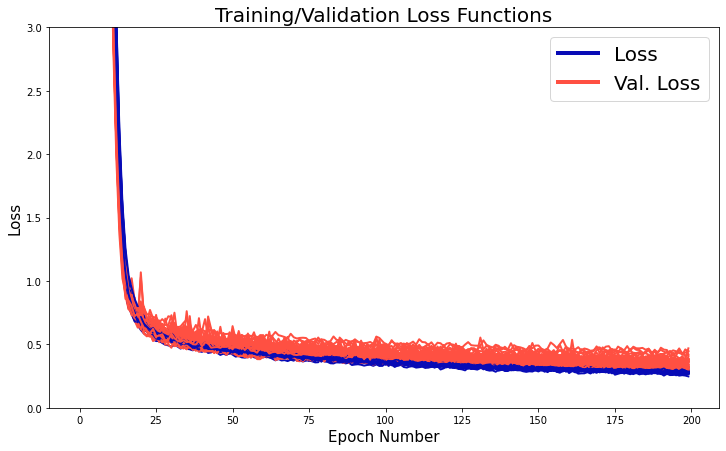

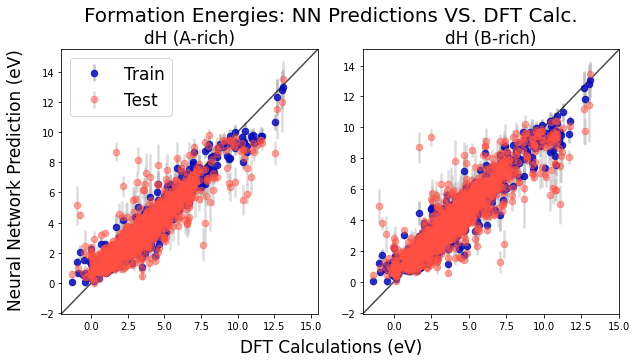

Average Train / Test RMSE with Uncertainty:
dH (A-rich): 0.653 +/- 0.028   /   0.972 +/- 0.094
dH (B-rich): 0.766 +/- 0.036   /   1.101 +/- 0.111

RMSE by defect site and SC type
---------------------------------------------------------
dH (A-rich)
Sub site: 1.097 +/- 0.173
Int site: 0.884 +/- 0.097
IIVI type: 0.685 +/- 0.047
IIIV type: 1.375 +/- 0.274
IVIV type: 1.512 +/- 0.280
dH (B-rich)
Sub site: 1.242 +/- 0.190
Int site: 1.002 +/- 0.124
IIVI type: 0.883 +/- 0.075
IIIV type: 1.434 +/- 0.273
IVIV type: 1.549 +/- 0.363


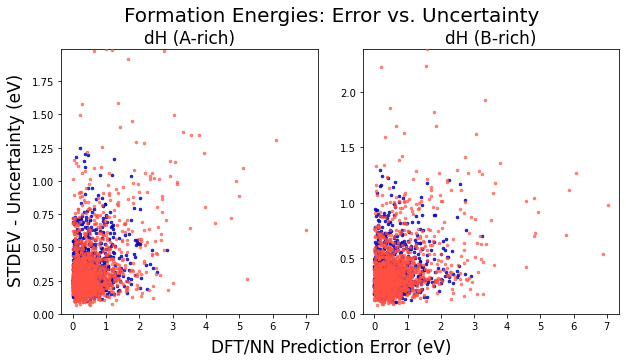

In [6]:
# data preprocessing
df, output_scaler, input_scaler = NeuralNetwork.data_prep(df)
print("df columns: " + str(df.shape[1]))
print("full df columns: " + str(df_full.shape[1]))
print("")

# run k-fold
(train_result,
 test_result) = NeuralNetwork.run_k_fold(df, epochs=epochs, bs=batch_size,
                                          lr=learning_rate, decay=adam_decay,
                                          dropout=dropout, noise=noise,
                                          k_reg=kernal_regularizer,
                                          hid_layer_neurons=hidden_neurons, 
                                          verbose=verbose, folds=k_folds, 
                                          repeats=repetition, rs=random_state, 
                                          graph=plot_graph, 
                                          output_scaler=output_scaler, 
                                          input_scaler=input_scaler,
                                          df_full=df_full, beta1=beta1, 
                                          beta2=beta2, amsgrad=amsgrad)